## Reducing the dimensionality of the data

In [39]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Whichever method of dimensionality reduction that we choose, we still have to make sure that the lower dimension variables explain a **significant proportion** of the original data.(90%)?.

So what happens when we run this algorithm?

What happens when we run regression on PCA?

We are predicting the dependent variable based on patterns of co-variation in the inputs, rather than individual features. So coefficients are not directly interpretable per variable. Instead, we interpret which group of features each component represents.

### With GWR

We're fitting a local regression model at each h3 cell here, using sptially weighted data from nearby cells. Instead of one global coefficient for each predictor, you get a surface of coefficients, one per h3, indicating that relationships vary across space.

So essentially - GWR tells you where each of your variables are more strongly linked to the dependent variable (in this case, the KPI). So in that sense, perhaps it makes some sense to have some explainability within the PCA.

> Lasso regression or scikit feature selection for clustering the variables

### So... the framework

1. Join all H3 datasets → one large GeoDataFrame.
2. Standardize / normalize features.
3. Apply PCA to reduce dimensionality:
    * per thematic block (POIs, buildings, greenness, etc.)
4. Fit regression models:
    * Global OLS or spatial lag/error regression → for baseline relationships.
    * GWR → to see where relationships vary spatially.
5. Map local coefficients → interpret which urban features (or principal components) are locally more important.


## It's probably best to PCA the datasets indiviudally so the PCA clusters can be conceptually similar

In [40]:
# python
from pathlib import Path
import sys

repo_root = Path.cwd() if (Path.cwd() / "src").exists() else Path.cwd().parent
sys.path.append(str(repo_root / "src"))

from config import PROCESSED_DATA_DIR
import geopandas as gpd

gdf = gpd.read_parquet(PROCESSED_DATA_DIR / "barcelona_h3_res10_landuse_aggregated.parquet")

In [41]:
#read in datasets individually
landuse = gpd.read_parquet('../data/processed/barcelona_h3_res10_landuse_aggregated.parquet')
ndvi = gpd.read_parquet('../data/processed/barcelona_h3_res10_ndvi_aggregated.parquet')
pois = gpd.read_parquet('../data/processed/barcelona_h3_res10_poi.parquet')
buildings = gpd.read_parquet('../data/processed/barcelona_h3_res10_building_aggregated.parquet')

In [ ]:
print(landuse.columns.shape) # we only want to use the pct area columns here
print(ndvi.columns.shape) # I'm assuming here that these dummy columns refer to % of clustered category in each h3 cell.
print(pois.columns.shape)
print(buildings.columns.shape) # we only want to use the pct area columns here

In [42]:
#we only want to keep the columns that start with pct_area_ for landuse and buildings
landuse_features = [col for col in landuse.columns if col.startswith('pct_area_')]
landuse_df = landuse[landuse_features]
print("new landuse cols = " + str(landuse_df.shape[1]))
buildings_features = [col for col in buildings.columns if col.startswith('pct_area_')]
buildings_df = buildings[buildings_features]
buildings_df.shape
print("new buildings cols = " + str(buildings_df.shape[1]))

new landuse cols = 17
new buildings cols = 13


#### Now

For each of these rows, they should not add up above 100, as they are % cover. In the aggregation step during the clustering, the % of each column is added, so in this case we do not want any rows that total >100 (or 1)

In [38]:
# find rows that have any value > 100
mask = landuse_df.gt(100).any(axis=1)
print("offending rows:", mask.sum())

# show offending rows (first 10)
landuse_df.loc[mask].head(10)

# show only the offending columns/values for those rows
off_cols = landuse_df.columns[landuse_df.gt(100).any()]
landuse_df.loc[mask, off_cols].head(10)

offending rows: 2435


,pct_area_agriculture,pct_area_cemetery,pct_area_construction,pct_area_developed,pct_area_education,pct_area_entertainment,pct_area_horticulture,pct_area_managed,pct_area_medical,pct_area_military,pct_area_park,pct_area_pedestrian,pct_area_recreation,pct_area_residential,pct_area_transportation
46,0.0,0.0,0.000000,1965.109441,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
47,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,382.989027,0.0
49,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,109.290048,0.0,0.000000,0.000000,0.0,772.743777,0.0
55,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,194.787497,0.0,0.000000,0.0
56,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,126.201957,0.000000,0.0,0.000000,0.0
57,0.0,0.0,2091.920126,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
59,0.0,0.0,0.000000,1656.727899,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
61,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,475.739399,0.0
64,0.0,0.0,101.018750,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,522.557361,0.0
66,0.0,0.0,0.000000,0.000000,215.581564,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0


In [35]:
checking_df = landuse_df.copy()
# detect scale (if values >1 then likely 0-100)
if checking_df.max().max() > 1.0:
    print("Values appear to be 0-100 scale — converting to 0-1 by dividing by 100")
    df_pct = checking_df / 100.0
else:
    df_pct = checking_df.astype(float)

# compute row sums
row_sums = df_pct.sum(axis=1)
# tolerance for floating point
tol = 1e-6
bad_mask = row_sums > 1.0 + tol
assert (row_sums <= 1.0 + tol).all(), "Some rows exceed 1.0"

Values appear to be 0-100 scale — converting to 0-1 by dividing by 100


AssertionError: Some rows exceed 1.0

> Over 400 columns after joining, with a significant weighting to pois. NDVI is *probably* fine, but the others will need some sort of clustering

#### Why don't we cluster them together?

If we mix the datasets, we're losing structure and interpretability. We'll be clustering counts with POIs and building types in heterogenous clusters, creating garbage clusters that mean very little.

In [61]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


# --------------------------------------------------------------
# Clean column names before embedding
# --------------------------------------------------------------
def clean_column_name(col):
    """Remove prefixes and format column names nicely for embedding."""
    replacements = [
        "num_polygons_", "num_buildings_", "pct_area_", "area_", 
        "avg_polygon_area_", "avg_", "_mean", "_count", "_total"
    ]

    clean = col
    for r in replacements:
        clean = clean.replace(r, "")
    clean = clean.replace("_", " ")

    return clean.strip()


# --------------------------------------------------------------
# Extract descriptive cluster names (local TF-IDF)
# --------------------------------------------------------------
def extract_keywords(columns, top_k=3):
    cleaned = [clean_column_name(c) for c in columns]

    vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,2))
    X = vectorizer.fit_transform(cleaned)

    scores = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vectorizer.get_feature_names_out())

    if len(vocab) == 0:
        return ["misc"]

    top = vocab[np.argsort(scores)[-top_k:]]
    return top.tolist()


def descriptive_cluster_name(columns, dataset_prefix):
    keywords = extract_keywords(columns, top_k=3)
    return f"{dataset_prefix}_" + "_".join(keywords)


# --------------------------------------------------------------
# Main function: semantic clustering + aggregation
# --------------------------------------------------------------
def reduce_semantic_features(
    df,
    dataset_prefix,
    prefix_filter="",
    n_clusters=4,
    model_name="all-MiniLM-L6-v2"
):
    """
    df              : dataframe containing landuse / POIs / buildings
    dataset_prefix  : string to prepend to output names (e.g., "landuse")
    prefix_filter   : restrict to columns beginning with this prefix ("" means no filter)
    n_clusters      : number of semantic clusters to form
    model_name      : sentence-transformers model used for embedding
    """

    print(f"\nLoading embedding model: {model_name} ...")
    model = SentenceTransformer(model_name)

    # ---------------------------
    # 1. Select numeric columns
    # ---------------------------
    numeric_cols = [
        c for c in df.columns
        if pd.api.types.is_numeric_dtype(df[c])
        and c.startswith(prefix_filter)
    ]

    print(f"Found {len(numeric_cols)} numeric columns for clustering.")

    if len(numeric_cols) == 0:
        raise ValueError("No numeric columns found for reduction.")

    cleaned_names = [clean_column_name(c) for c in numeric_cols]

    # ---------------------------
    # 2. Embed column names
    # ---------------------------
    print("\nEmbedding column names...")
    embeddings = model.encode(cleaned_names, show_progress_bar=True)

    # ---------------------------
    # 3. Cluster embeddings
    # ---------------------------
    print(f"\nClustering into {n_clusters} semantic groups...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)

    clusters = {i: [] for i in range(n_clusters)}
    for col, lab in zip(numeric_cols, labels):
        clusters[lab].append(col)

    # ---------------------------
    # 4. Assign descriptive names
    # ---------------------------
    cluster_names = {}
    for cluster_id, cols in clusters.items():
        name = descriptive_cluster_name(cols, dataset_prefix)
        cluster_names[cluster_id] = name

    # ---------------------------
    # 5. Aggregate per cluster
    # ---------------------------
    reduced_df = pd.DataFrame(index=df.index)

    for cluster_id, col_list in clusters.items():
        name = cluster_names[cluster_id]

        # Aggregate:
        # - percentage columns: mean (since they are 0-100 % cover)
        # - count columns: sum
        if all(c.startswith("pct_") or "pct_" in c for c in col_list):
            reduced_df[name] = df[col_list].mean(axis=1)
        else:
            reduced_df[name] = df[col_list].sum(axis=1)

    # ---------------------------
    # 6. Report
    # ---------------------------
    print("\nGenerated aggregated clusters:")
    for cid, name in cluster_names.items():
        print(f"\n{name}:")
        print(f"  {len(clusters[cid])} columns")
        print(f"  example: {clusters[cid][:5]} ...")

    return reduced_df, clusters, cluster_names


In [62]:
landuse_reduced, landuse_clusters, landuse_names = reduce_semantic_features(landuse_df,
    dataset_prefix="landuse",
    prefix_filter="pct_area_",
    n_clusters=4)


Loading embedding model: all-MiniLM-L6-v2 ...
Found 17 numeric columns for clustering.

Embedding column names...


Batches: 100%|██████████| 1/1 [00:00<00:00, 26.24it/s]


Clustering into 4 semantic groups...

Generated aggregated clusters:

landuse_golf:
  1 columns
  example: ['pct_area_golf'] ...

landuse_military_religious_transportation:
  8 columns
  example: ['pct_area_agriculture', 'pct_area_education', 'pct_area_entertainment', 'pct_area_managed', 'pct_area_medical'] ...

landuse_developed_horticulture_residential:
  4 columns
  example: ['pct_area_construction', 'pct_area_developed', 'pct_area_horticulture', 'pct_area_residential'] ...

landuse_park_pedestrian_recreation:
  4 columns
  example: ['pct_area_cemetery', 'pct_area_park', 'pct_area_pedestrian', 'pct_area_recreation'] ...


In [64]:
buildings_reduced, buildings_clusters, buildings_names = reduce_semantic_features(buildings_df, 
                                                                                  dataset_prefix="buildings",
                                                                                  prefix_filter="", 
                                                                                  n_clusters=4)


Loading embedding model: all-MiniLM-L6-v2 ...
Found 13 numeric columns for clustering.

Embedding column names...


Batches: 100%|██████████| 1/1 [00:00<00:00, 18.91it/s]


Clustering into 4 semantic groups...

Generated aggregated clusters:

buildings_entertainment_medical_religious:
  6 columns
  example: ['pct_area_agricultural', 'pct_area_commercial', 'pct_area_education', 'pct_area_entertainment', 'pct_area_medical'] ...

buildings_military_service_transportation:
  4 columns
  example: ['pct_area_industrial', 'pct_area_military', 'pct_area_service', 'pct_area_transportation'] ...

buildings_civic_residential:
  2 columns
  example: ['pct_area_civic', 'pct_area_residential'] ...

buildings_outbuilding:
  1 columns
  example: ['pct_area_outbuilding'] ...


In [65]:
pois_reduced, pois_clusters, pois_names = reduce_semantic_features(pois, 
                                                                   dataset_prefix="pois",
                                                                    prefix_filter="", 
                                                                    n_clusters=4)


Loading embedding model: all-MiniLM-L6-v2 ...
Found 357 numeric columns for clustering.

Embedding column names...


Batches: 100%|██████████| 12/12 [00:00<00:00, 58.37it/s]


Clustering into 4 semantic groups...

Generated aggregated clusters:

pois_salon_shop_store:
  58 columns
  example: ['antique_shop', 'art_craft_hobby_store', 'auto_body_shop', 'b2b_supplier_distributor', 'bakery'] ...

pois_rental_rental service_service:
  108 columns
  example: ['accountant_or_bookkeeper', 'adoption_service', 'agricultural_service', 'air_transport_facility_service', 'airport_shuttle_service'] ...

pois_organization_school_animal:
  67 columns
  example: ['allergy_and_immunology', 'alternative_medicine', 'animal_boarding', 'animal_hospital', 'animal_rescue'] ...

pois_park_sport_station:
  124 columns
  example: ['accommodation', 'agricultural_area', 'airport', 'airport_terminal', 'amateur_sport_team'] ...


In [66]:
pois_geo = pois[['h3_id', 'geometry']].copy()
buildings_geo = buildings[['h3_id', 'geometry']].copy()
landuse_geo = landuse[['h3_id', 'geometry']].copy()

In [67]:
pois_reduced = pois_geo.join(pois_reduced)
buildings_reduced = buildings_geo.join(buildings_reduced)
landuse_reduced = landuse_geo.join(landuse_reduced)
ndvi_reduced = ndvi[['h3_id', 'geometry','mean_ndvi']].copy()

In [68]:
model_df = (
    landuse_reduced
    .merge(pois_reduced, on=['h3_id', 'geometry'], how='left')
    .merge(buildings_reduced, on=['h3_id', 'geometry'], how='left')
    .merge(ndvi_reduced, on=['h3_id', 'geometry'], how='left')
)

<Axes: >

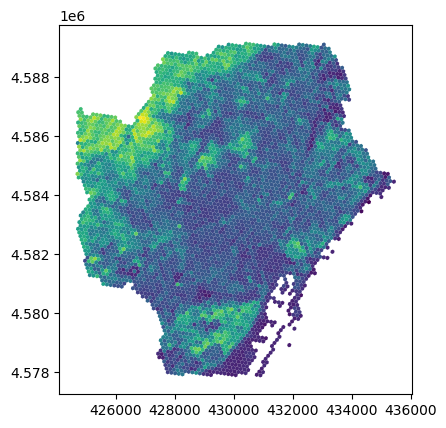

In [17]:
ndvi_reduced.plot(column='mean_ndvi')

In [20]:
model_df.head(3)

,h3_id,geometry,cluster_0_golf,cluster_1_military_religious_transportation,cluster_2_developed_horticulture_residential,cluster_3_park_pedestrian_recreation,cluster_0_salon_shop_store,cluster_1_utility_rental_service,cluster_2_care_animal_school,cluster_3_place_station_sport,cluster_0_entertainment_medical_religious,cluster_1_military_service_transportation,cluster_2_civic_residential,cluster_3_outbuilding,mean_ndvi
0,8a394461b98ffff,"POLYGON ((430592.392 4576915.43, 430577.5 4576...",0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN
1,8a394461b92ffff,"POLYGON ((430681.742 4577368.251, 430666.851 4...",0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN
2,8a394461b91ffff,"POLYGON ((430637.067 4577141.842, 430622.176 4...",0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN


We have a couple of NaNs, so let's see how removing **ANY** NaNs from the dataset affects the geographical representation

In [69]:
# remove rows with any NaN in any column
model_df_clean = model_df.dropna().reset_index(drop=True)

# quick check
print("before:", model_df.shape, "after:", model_df_clean.shape)
print(model_df_clean.isna().sum())

before: (6920, 15) after: (3233, 15)
h3_id                                         0
geometry                                      0
landuse_golf                                  0
landuse_military_religious_transportation     0
landuse_developed_horticulture_residential    0
landuse_park_pedestrian_recreation            0
pois_salon_shop_store                         0
pois_rental_rental service_service            0
pois_organization_school_animal               0
pois_park_sport_station                       0
buildings_entertainment_medical_religious     0
buildings_military_service_transportation     0
buildings_civic_residential                   0
buildings_outbuilding                         0
mean_ndvi                                     0
dtype: int64


<Axes: >

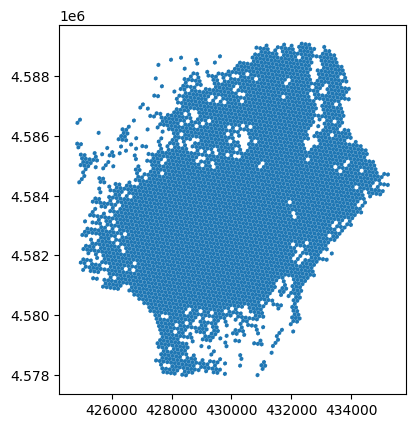

In [22]:
model_df_clean.plot()

It's a little spotty, but it will suffice for now. We need to be able to model each of our clusters.

In [70]:
#save the model_df as a geoparquet
model_df_clean.to_parquet(PROCESSED_DATA_DIR / "barcelona_h3_res10_model_features.parquet")